In [11]:
#%%
import numpy as np
import matplotlib.pyplot as plt
import os
from matplotlib import gridspec
#from pandas import DataFrame as DF
from scipy.io import readsav
from astropy.io import fits

# longs = np.zeros(0, float)

# a   : semi-major axis of planetary orbit (in Rstar)
# inc : inclination angle of orbital plane (in degrees)
# per : period of planetary orbit (in days), assumed circular orbit
# r   : stellar radius (in pixel)
# rp  : planetary radius (in Rstar) (1 Rjup = 6.9911e4 km = 0.100447 Rsun)
# tef : effective surface temperature (in kelvin)
# u1  :
# u2  :
# star_image  : white light image of star (or Sun)
# x0  :

#K63  = readsav('paramk63.save')

## convert -delay 10 -loop 1 ./K63_transit/*.png K63_transit.gif
run_model = 1
create_gif = 1
samples = 10
## use_last = 1

 
# arquivo FITS dos dados
nome = 'aia_171_level1.fits'
file171 = 'aia_lev1_171a_2022_10_01t13_30_09_35z_image_lev1.fits'
file1700 = 'aia.lev1.1700A_2014-02-25T00_44_30.71Z.image_lev1.fits'

hdul = fits.open(file171)
star_image = hdul[1].data # OS DADOS (IMAGENS) ESTAO AQUI

a = 19.55 ## semi-eixo maior da orbita (quase certeza que a orbita é circular)
inc = 92.7 # 90-2.9 ## 90 graus é no equador (confirmar!)
per = 9.43415 ## periodo (nao precisar mudar)
tef = 5576.0

u1 = 0.59 # not used
u2 = 0.0 # not used
x0 = 177.843 # not used

rp = 0.0662 ## raio do planeta
### r = 368.65082
print(hdul)
print(hdul[1].header)




[<astropy.io.fits.hdu.image.PrimaryHDU object at 0x7f814773abe0>, <astropy.io.fits.hdu.compressed.CompImageHDU object at 0x7f81475f0640>]
SIMPLE  =                    T / file does conform to FITS standard             BITPIX  =                   16 / data type of original image                    NAXIS   =                    2 / dimension of original image                    NAXIS1  =                 4096 / length of original image axis                  NAXIS2  =                 4096 / length of original image axis                  BLD_VERS= 'V9R5X'                                                               LVL_NUM = 1.000000                                                              T_REC   = '2022-10-01T13:30:10Z'                                                TRECSTEP= 1.000000                                                              TRECEPOC= '1977.01.01_00:00:00_TAI'                                             TRECROUN=                    1                                

20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160


TypeError: object of type 'float' has no len()

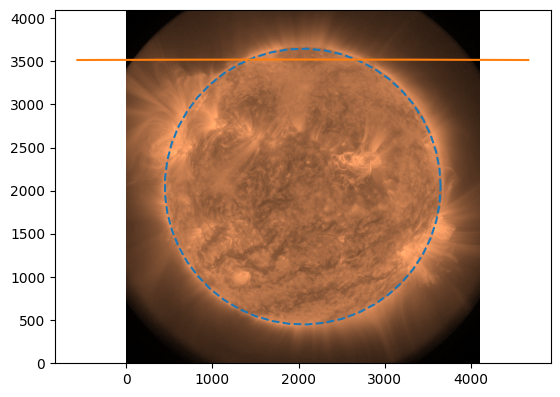

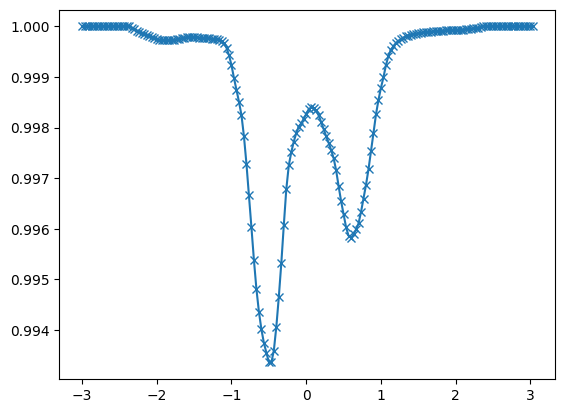

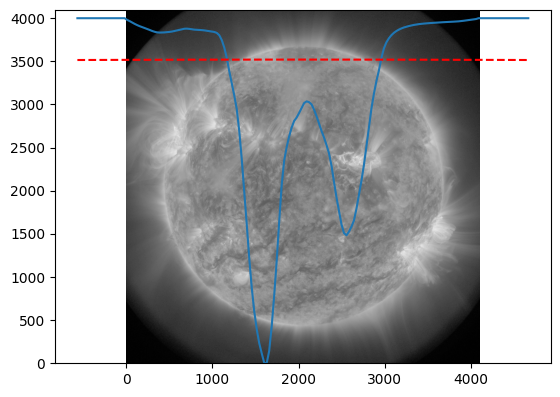

In [15]:

# r_pix = arcsec / (arcsec/pixel) = pixel
r = hdul[1].header['RSUN_OBS']/hdul[1].header['CDELT1'] # radius in arcsec


N = len(star_image[:, 0])

Rplan = rp * r      # planet radius in pixels
Rorbit = a * r      # orbital radius in pixels
alpha = np.radians(inc) # inclination angle of orbital plane [rad]


alpha_limit = np.arctan(r/Rorbit) + np.pi/2

if alpha < alpha_limit:
    dt = 30   
    t = per * 24. * dt
    
    phi = np.arange((t+0.5) - 1) * 360./(t)
    
    ii0 = np.where((180<=phi) & (phi<=360))
    phi = np.radians(phi[ii0])
    
    #theta = np.arccos(1.2*r/Rorbit)
    #phi = np.linspace(np.pi+theta,2*np.pi-theta,samples)
    
    Xorig = Rorbit * np.cos(phi)
    Yorig = Rorbit * np.sin(phi) * np.cos(alpha)
    
    edge = (N-2*r)/2/r+1 # 
    ii1 = np.where((abs(Xorig)<N/2*edge) & (abs(Yorig)<N/2))[0]
    X = Xorig[ii1];   Y = Yorig[ii1]
    TotalFlux = np.zeros(len(ii1))+np.sum(star_image)
    
    ii2 = np.argsort(X)
    X = X[ii2];   Y = Y[ii2]
    
    # show star and planet path
    image = star_image
    image[np.where(star_image<=0)]=1
    plt.imshow(np.log10(image),cmap='copper',aspect='equal',origin='lower')
    phi2 = np.linspace(0,2*np.pi,50)
    plt.plot(N/2+r*np.cos(phi2),N/2+r*np.sin(phi2),'--') # plot radius
    plt.plot(X+N/2,Y+N/2) # plot path
    
    Xstar, Ystar = X/r, Y/r
    
    X_wl = (np.arange(0, star_image.shape[0], 1) - star_image.shape[0]/2) / r
    Y_wl = (np.arange(0, star_image.shape[1], 1) - star_image.shape[1]/2) / r
    X_wl, Y_wl = np.meshgrid(X_wl, Y_wl)# X, Y matrix coordinates in Rstar
    
    RR_st = np.sqrt(Xstar**2 + Ystar**2)
    ii3 = np.where(RR_st==np.nanmin(RR_st))[0]
    lc_steps = (np.arange(len(ii1)) - ii3) / dt # light curve steps in hours
    
    # lat = (-np.arcsin((a) * np.cos(np.radians(inc))))/0.0174533
    # print(lat)
    # x1 = np.arange(0, N, dtype=float)-N/2
    # y1 = np.arange(0, N, dtype=float)-N/2
    
    nn = np.arange(N * N)
    
    ii4 = np.where((X+(N/2)>0) & (X+(N/2)<N) & (Y+(N/2)>0) & (Y+(N/2)<N))[0]
    i0 = ii4[0];   i1 = ii4[-1]
    
    
    # Model loop:
    if run_model:
        for i in np.arange(i0, i1):
          print(i)
          x0 = X[i]+N/2;   x0star = x0/r
          y0 = Y[i]+N/2;   y0star = y0/r
        
          planet = np.ones((1, N*N), dtype=float) # matriz de N por N
          ii5 = np.where(np.sqrt((nn/N-y0)**2 + (nn-N*np.floor(nn/N)-x0)**2)<Rplan)[0]
          planet[0][ii5] = 0
          planet = planet.reshape(-1, N)
        
          Eclipse = star_image * planet
          TotalFlux[i] = np.sum(Eclipse, dtype=float)
        
        light_curve = TotalFlux/TotalFlux[0]
        lc_min, lc_max = np.nanmin(light_curve), np.nanmax(light_curve)
        yl = (lc_max-lc_min)*.1;   ylim = lc_min-yl, lc_max+yl
        
        ## SHOW TRANSIT
        fig1=plt.figure()
        plt.plot(lc_steps,light_curve,'-x')
        
        fig2=plt.figure()
        plt.imshow(np.log10(image),cmap='gray',aspect='equal',origin='lower')
        plt.plot(X+N/2,np.interp(light_curve, (light_curve.min(), light_curve.max()), (0, 4000)))
        plt.plot(X+N/2,Y+N/2,'--r')
        
        np.save('lcsteps.npy',lc_steps)
        np.save('lc.npy',light_curve)
        np.save('X.npy',X)
        np.save('Y.npy',Y)
        np.save('image.npy',image)
        
    if create_gif:
        ax_col = '#707070';   cmap = 'copper'# 'gist_heat'#
        sav_dir = 'K63_transit/'
        if not os.path.isdir(sav_dir): os.makedirs(sav_dir)
        
        plot_range = np.arange(int(samples / 2))  # ou range(int(samples / 2))
        print(i0, 'to', i1, 'len:', len(plot_range))
        
        for i in plot_range:
          x0 = X[i]+N/2;   x0star = x0/r
          y0 = Y[i]+N/2;   y0star = y0/r
        
          planet = np.ones((1, N*N), dtype=float) # matriz de N por N
          ii5 = np.where(np.sqrt((nn/N-y0)**2 + (nn-N*np.floor(nn/N)-x0)**2)<Rplan)[0]
          planet[0][ii5] = 0
          planet = planet.reshape(-1, N)
        
          Eclipse = star_image * planet
        
          # Plots:
          fig = plt.figure(figsize=(6, 6))
          gs = gridspec.GridSpec(10, 1)#, width_ratios=[1, 1])
        
          ax = plt.subplot(gs[:6, :]);   ax.set_aspect(1);   ax.set_facecolor('k')
          ax.pcolormesh(X_wl, Y_wl, Eclipse, cmap=cmap, shading='gouraud')
          ax.plot(Xstar, Ystar, '-.', lw=1, alpha=.7)
          if 0:# marcação do planeta
            xplan = np.mean(X_wl.ravel()[ii5]);   yplan = np.mean(Y_wl.ravel()[ii5])
            ax.plot(xplan, yplan, '.,')
          ax.grid(c=ax_col, alpha=.3, lw=.5)
          ax.set_xlabel('$R_{star}$')
          ax.set_ylabel('$R_{star}$')
          ax.set_xlim(Xstar[0], Xstar[-1])
          for sp in ('left','bottom','right','top'): ax.spines[sp].set_color(ax_col)
          ax.xaxis.label.set_color(ax_col);   ax.yaxis.label.set_color(ax_col)
          ax.tick_params(axis='both', which='both', colors=ax_col)
        
          ax = plt.subplot(gs[7:, :]);   ax.set_facecolor('k')
          ax.plot(lc_steps[i0:i], light_curve[i0:i])
          ax.grid(c=ax_col, alpha=.3, lw=.5)
          ax.set_xlabel('time (h)')
          ax.set_ylabel('relative flux')
          ax.set_xlim(lc_steps[i0], lc_steps[i1])
          ax.set_ylim(ylim)
          for sp in ('left','bottom','right','top'): ax.spines[sp].set_color(ax_col)
          ax.xaxis.label.set_color(ax_col);   ax.yaxis.label.set_color(ax_col)
          ax.tick_params(axis='both', which='both', colors=ax_col)
        
          fig.savefig(sav_dir+'K63_transit_%04d'%i, facecolor='#010101FF', dpi=80)
          fig.clf()
        
          #print(i)
else:
    print('NO TRANSIT ++++++++++++++++++++++++++++++')

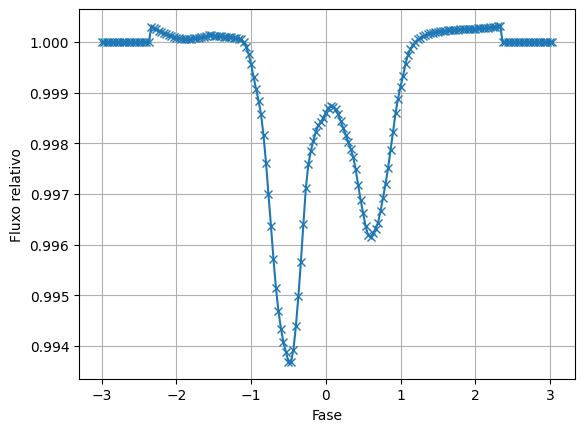

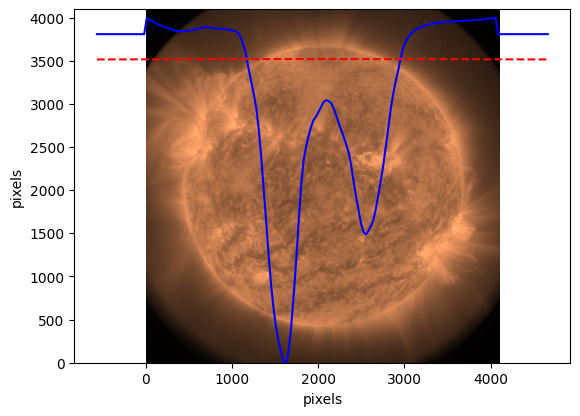

In [13]:
# -*- coding: utf-8 -*-
"""
Created on Wed Apr 21 17:27:41 2021

@author: pjasi
"""

## SHOW TRANSIT
import matplotlib.pyplot as plt
import numpy as np

lc_steps = np.load('lcsteps.npy') #lc_steps
light_curve = np.load('lc.npy') # light_curve
X = np.load('X.npy') # X
Y = np.load('Y.npy') # Y
image = np.load('image.npy') # image 
N = len(image)

fig1=plt.figure()
plt.plot(lc_steps,light_curve,'-x')
plt.grid()
plt.xlabel('Fase')
plt.ylabel('Fluxo relativo')

fig2=plt.figure()
plt.imshow(np.log(image),cmap='copper',aspect='equal',origin='lower')
plt.plot(X+N/2,np.interp(light_curve, (light_curve.min(), light_curve.max()), (0, 4000)),color='b')
plt.plot(X+N/2,Y+N/2,'--r')
plt.xlabel('pixels')
plt.ylabel('pixels')
plt.savefig('exemplo.png')
